In [0]:
import sys, os, time
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

1.4.0


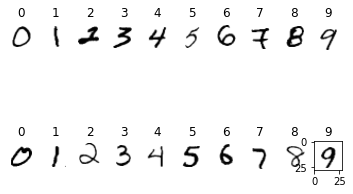

In [0]:
train_mnist=datasets.MNIST('data', train=True, download=True)
y_train_orig=train_mnist.targets.numpy()
for i in range(10):
  num_digits=2
  indices=np.random.choice(np.where(y_train_orig==i)[0],num_digits)
  for j in range(num_digits):
    plt.axis('off')
    plt.subplot(num_digits,10,10*j+i+1).set_title('{}'.format(i))
    img,_=train_mnist[indices[j]]
    plt.imshow(img, cmap='Greys')
plt.show()

In [0]:
batch_size = 128
use_cuda = torch.cuda.is_available()
print(use_cuda)

torch.manual_seed(1)

normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST

train_transform=transforms.Compose([
                        transforms.ToTensor(),
                        normalize
                    ])
train_dataset = datasets.MNIST(root='data', train=True, 
                download=True, transform=train_transform)


test_transform=transforms.Compose([
                        transforms.ToTensor(),
                        normalize
                    ])
test_dataset = datasets.MNIST(root='data', train=False, 
            download=True, transform=test_transform)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))
num_train = len(train_dataset)
split = int(np.floor(0.1 * num_train))
train_set, val_set = torch.utils.data.random_split(train_dataset, [num_train-split, split])
print(len(train_set), len(val_set))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size, shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False, **kwargs)

True
54000 6000


In [0]:
input_size=train_dataset[0][0].shape
num_classes=len(train_dataset.classes)

class Net(nn.Module):
    def __init__(self,
                 n_hidden,
                 dropout,
                 do_first_layer=True):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(np.prod(input_size), n_hidden)
        self.fc1 = nn.Linear(n_hidden, n_hidden*2)
        self.fc2 = nn.Linear(n_hidden*2, n_hidden)
        self.out = nn.Linear(n_hidden, num_classes)
        self.dropout = nn.Dropout(dropout, )
        self.do_first_layer = do_first_layer

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc0(x)
        if self.do_first_layer:
            x = self.dropout(x)
        x_relu1 = self.fc1(x).clamp(min=0)  # basically relu
        x = self.dropout(x_relu1)
        x_relu2 = self.fc2(x_relu1).clamp(min=0)  # basically relu
        x = self.dropout(x_relu2)
        x = self.out(x)
        output = F.log_softmax(x, dim=1)
        return output

In [0]:
def train(model, device, train_loader, optimizer, epoch, mute=False):
  train_loss = 0.0
  total_train = 0
  correct_train = 0
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = F.nll_loss(output, target)
      loss.backward()
      optimizer.step()
      if (batch_idx % 10 == 0 and not mute):
        display('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()), display_id=str(epoch), update=True)
      
      # accuracy
      _, predicted = torch.max(output.data, 1)
      train_loss += loss.item()
      total_train += target.nelement()  # number of pixel in the batch
      correct_train += predicted.eq(target.data).sum().item() # sum all precited pixel values
  
  epoch_loss = train_loss / len(train_loader.dataset)
  epoch_acc = 100.*(correct_train / total_train)
  if not mute:
      print('Train set: Average loss: {:.4f}, Accuracy: {}/{} {:.0f}%\n'.format(
      epoch_loss,correct_train, total_train, epoch_acc))
  return epoch_loss,epoch_acc

In [0]:
def test(model, device, test_loader, mute=False):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  accuracy=100. * correct / len(test_loader.dataset)

  if not mute:
      print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      accuracy))
  return test_loss,accuracy

In [0]:
def init_weights_xavier(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [0]:
def init_weights_he(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)

In [0]:
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
epochs = 30

start_time = time.time()

model = Net(1200, 0.4).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)

In [0]:
model.apply(init_weights_xavier)

Net(
  (fc0): Linear(in_features=784, out_features=1200, bias=True)
  (fc1): Linear(in_features=1200, out_features=2400, bias=True)
  (fc2): Linear(in_features=2400, out_features=1200, bias=True)
  (out): Linear(in_features=1200, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [0]:
train_accuracies,val_accuracies=[],[]
train_losses,val_losses=[],[]
for epoch in range(1, epochs + 1):
    epoch_start = time.time()
    train_loss,train_accuracy=train(model, device, train_loader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    scheduler.step()
    epoch_time = round(time.time() - epoch_start, 2)
    print(f'Epoch Train Time: {int(epoch_time // 60)}m {epoch_time % 60}s\n')

elapsed = time.time() - start_time
print(f'Training complete in {int(elapsed // 60)}m {elapsed // 60}s')

'Train Epoch: 1 [53760/54000 (100%)] Loss: 0.333799'

Train set: Average loss: 0.0024, Accuracy: 49186/54000 91%

Val set: Average loss: 0.2011, Accuracy: 5666/6000 (94%)

Epoch Train Time: 0m 9.46s



'Train Epoch: 2 [53760/54000 (100%)] Loss: 0.111017'

Train set: Average loss: 0.0013, Accuracy: 51330/54000 95%

Val set: Average loss: 0.1552, Accuracy: 5727/6000 (95%)

Epoch Train Time: 0m 9.35s



'Train Epoch: 3 [53760/54000 (100%)] Loss: 0.120124'

Train set: Average loss: 0.0009, Accuracy: 52182/54000 97%

Val set: Average loss: 0.1029, Accuracy: 5815/6000 (97%)

Epoch Train Time: 0m 9.39s



'Train Epoch: 4 [53760/54000 (100%)] Loss: 0.090298'

Train set: Average loss: 0.0007, Accuracy: 52482/54000 97%

Val set: Average loss: 0.0925, Accuracy: 5832/6000 (97%)

Epoch Train Time: 0m 9.44s



'Train Epoch: 5 [53760/54000 (100%)] Loss: 0.068606'

Train set: Average loss: 0.0005, Accuracy: 53001/54000 98%

Val set: Average loss: 0.0933, Accuracy: 5851/6000 (98%)

Epoch Train Time: 0m 9.39s



'Train Epoch: 6 [53760/54000 (100%)] Loss: 0.030266'

Train set: Average loss: 0.0004, Accuracy: 53082/54000 98%

Val set: Average loss: 0.0860, Accuracy: 5866/6000 (98%)

Epoch Train Time: 0m 9.58s



'Train Epoch: 7 [53760/54000 (100%)] Loss: 0.094050'

Train set: Average loss: 0.0003, Accuracy: 53397/54000 99%

Val set: Average loss: 0.0679, Accuracy: 5888/6000 (98%)

Epoch Train Time: 0m 9.46s



'Train Epoch: 8 [53760/54000 (100%)] Loss: 0.014922'

Train set: Average loss: 0.0002, Accuracy: 53443/54000 99%

Val set: Average loss: 0.0777, Accuracy: 5892/6000 (98%)

Epoch Train Time: 0m 9.31s



'Train Epoch: 9 [53760/54000 (100%)] Loss: 0.012428'

Train set: Average loss: 0.0002, Accuracy: 53616/54000 99%

Val set: Average loss: 0.0759, Accuracy: 5887/6000 (98%)

Epoch Train Time: 0m 9.36s



'Train Epoch: 10 [53760/54000 (100%)] Loss: 0.006171'

Train set: Average loss: 0.0001, Accuracy: 53721/54000 99%

Val set: Average loss: 0.0653, Accuracy: 5906/6000 (98%)

Epoch Train Time: 0m 9.4s



'Train Epoch: 11 [53760/54000 (100%)] Loss: 0.035224'

Train set: Average loss: 0.0001, Accuracy: 53757/54000 100%

Val set: Average loss: 0.0704, Accuracy: 5906/6000 (98%)

Epoch Train Time: 0m 9.42s



'Train Epoch: 12 [53760/54000 (100%)] Loss: 0.006934'

Train set: Average loss: 0.0001, Accuracy: 53811/54000 100%

Val set: Average loss: 0.0706, Accuracy: 5895/6000 (98%)

Epoch Train Time: 0m 9.33s



'Train Epoch: 13 [53760/54000 (100%)] Loss: 0.002823'

Train set: Average loss: 0.0001, Accuracy: 53879/54000 100%

Val set: Average loss: 0.0730, Accuracy: 5901/6000 (98%)

Epoch Train Time: 0m 9.43s



'Train Epoch: 14 [53760/54000 (100%)] Loss: 0.022831'

Train set: Average loss: 0.0001, Accuracy: 53872/54000 100%

Val set: Average loss: 0.0690, Accuracy: 5907/6000 (98%)

Epoch Train Time: 0m 9.71s



'Train Epoch: 15 [53760/54000 (100%)] Loss: 0.000757'

Train set: Average loss: 0.0000, Accuracy: 53909/54000 100%

Val set: Average loss: 0.0674, Accuracy: 5906/6000 (98%)

Epoch Train Time: 0m 9.52s



'Train Epoch: 16 [53760/54000 (100%)] Loss: 0.000538'

Train set: Average loss: 0.0000, Accuracy: 53942/54000 100%

Val set: Average loss: 0.0690, Accuracy: 5908/6000 (98%)

Epoch Train Time: 0m 9.26s



'Train Epoch: 17 [53760/54000 (100%)] Loss: 0.000244'

Train set: Average loss: 0.0000, Accuracy: 53950/54000 100%

Val set: Average loss: 0.0633, Accuracy: 5910/6000 (98%)

Epoch Train Time: 0m 9.33s



'Train Epoch: 18 [53760/54000 (100%)] Loss: 0.000131'

Train set: Average loss: 0.0000, Accuracy: 53953/54000 100%

Val set: Average loss: 0.0698, Accuracy: 5909/6000 (98%)

Epoch Train Time: 0m 9.39s



'Train Epoch: 19 [53760/54000 (100%)] Loss: 0.000032'

Train set: Average loss: 0.0000, Accuracy: 53957/54000 100%

Val set: Average loss: 0.0705, Accuracy: 5913/6000 (99%)

Epoch Train Time: 0m 9.25s



'Train Epoch: 20 [53760/54000 (100%)] Loss: 0.001428'

Train set: Average loss: 0.0000, Accuracy: 53965/54000 100%

Val set: Average loss: 0.0694, Accuracy: 5916/6000 (99%)

Epoch Train Time: 0m 9.38s



'Train Epoch: 21 [53760/54000 (100%)] Loss: 0.001527'

Train set: Average loss: 0.0000, Accuracy: 53967/54000 100%

Val set: Average loss: 0.0696, Accuracy: 5917/6000 (99%)

Epoch Train Time: 0m 9.44s



'Train Epoch: 22 [53760/54000 (100%)] Loss: 0.000109'

Train set: Average loss: 0.0000, Accuracy: 53976/54000 100%

Val set: Average loss: 0.0703, Accuracy: 5915/6000 (99%)

Epoch Train Time: 0m 9.35s



'Train Epoch: 23 [53760/54000 (100%)] Loss: 0.000101'

Train set: Average loss: 0.0000, Accuracy: 53973/54000 100%

Val set: Average loss: 0.0706, Accuracy: 5911/6000 (99%)

Epoch Train Time: 0m 9.49s



'Train Epoch: 24 [53760/54000 (100%)] Loss: 0.002455'

Train set: Average loss: 0.0000, Accuracy: 53977/54000 100%

Val set: Average loss: 0.0707, Accuracy: 5913/6000 (99%)

Epoch Train Time: 0m 9.38s



'Train Epoch: 25 [53760/54000 (100%)] Loss: 0.000978'

Train set: Average loss: 0.0000, Accuracy: 53981/54000 100%

Val set: Average loss: 0.0683, Accuracy: 5918/6000 (99%)

Epoch Train Time: 0m 9.54s



'Train Epoch: 26 [53760/54000 (100%)] Loss: 0.000347'

Train set: Average loss: 0.0000, Accuracy: 53974/54000 100%

Val set: Average loss: 0.0678, Accuracy: 5922/6000 (99%)

Epoch Train Time: 0m 9.39s



'Train Epoch: 27 [53760/54000 (100%)] Loss: 0.014362'

Train set: Average loss: 0.0000, Accuracy: 53979/54000 100%

Val set: Average loss: 0.0688, Accuracy: 5920/6000 (99%)

Epoch Train Time: 0m 9.29s



'Train Epoch: 28 [53760/54000 (100%)] Loss: 0.000114'

Train set: Average loss: 0.0000, Accuracy: 53987/54000 100%

Val set: Average loss: 0.0690, Accuracy: 5923/6000 (99%)

Epoch Train Time: 0m 9.33s



'Train Epoch: 29 [53760/54000 (100%)] Loss: 0.000483'

Train set: Average loss: 0.0000, Accuracy: 53986/54000 100%

Val set: Average loss: 0.0694, Accuracy: 5922/6000 (99%)

Epoch Train Time: 0m 9.35s



'Train Epoch: 30 [53760/54000 (100%)] Loss: 0.000156'

Train set: Average loss: 0.0000, Accuracy: 53985/54000 100%

Val set: Average loss: 0.0687, Accuracy: 5921/6000 (99%)

Epoch Train Time: 0m 9.39s

Training complete in 4m 4.0s


30 30


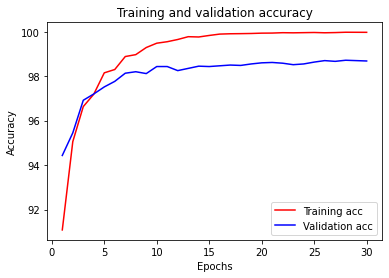

In [0]:
print(len(train_accuracies),len(val_accuracies))
epochs = range(1, len(train_accuracies) + 1)

plt.plot(epochs, train_accuracies, 'r', label='Training acc')
plt.plot(epochs, val_accuracies, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

30 30


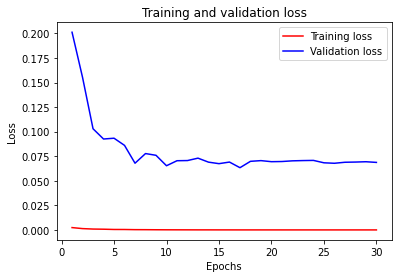

In [0]:
print(len(train_losses),len(val_losses))
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
score = test(model, device, test_loader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.0717, Accuracy: 9874/10000 (99%)

Test loss: 0.07174887809753418
Test accuracy: 98.74


### SGD tests (lr 0.1)
- From the start: dropout (0.3); increased number of hidden layers (1) and nodes (1000): **94%**;
- 2 hidden (784, 1000, 2000, 1000, out); Relu at fc1 and fc2: **98.06%**;
- Dropout 0.4 and 0.35 peaked ~ 97.73%. It appears that 0.3 is the best, but we'll try less instead.
- 1200-2400: **98.17%**;
- Decreasing dropout to 0.2 yielded worse results on both dev and test sets. Seems like 0.3 is the best.
- Increasing number of neurons until it caps the accuracy by this means (should not exactly overfit since we have regularization)
- Both dev and test accuracy decreased at 1400. Seems like 1200 is the best choice for 2-layer configuration.
- 0.1 -> 0.05 lr. Appears stuck on a suboptimal solution *(97.5%)*.
- 0.7 -> 0.5 scheduler gamma - worse;
- Not dropping out fc0: *98.13%*.
- Avg time: 4m 04s per 20 epochs.

### Adam (lr 0.001):
- **98.49%**. It appears that change in optimizer did not affect training time (4:04 as before)
- Dev loss fluctuates wildly; let's try larger dropout, 0.4.
- Larger dropout did not affect accuracy at all. However, dev loss optima (according to graph) was at ~18 epochs. Let's train less.
- It was a correct decision: 18 epochs yielded **98.62%**.
- 1400 nodes, old (0.3) dropout: *98.59*.
- Best parameters so far: 1200 + 0.4 at 18 epochs. Let's play with regularization.
- Introduced **weight decay (l2 regularization)** to Adam while keeping dropout.
- 0.1: immediate sharp decrease, did not go past first two epochs;
- 0.01: seems stuck at a suboptimal solution.
- 0.001: 98.26%.
- 0.001 + 0.3 d/o: 98.31%, although l2 in combination with d/o doesn't seem to be working out as well. Let's turn off dropout.
- L2 alone yields worse results than initial net. It seems d/o is better suited for the task.

## Trying different weight initializations

Since we are using ReLU, standard initializations to try would be Xavier and Kaiming (He et al., 2015). Let's try both.
- Xavier: immediately improved accuracy on the same 20 epochs to 98.58% (there is, however, no local optimum for val loss in the closest epochs). Additionally, training time drastically improved, dropping from 4:04 to 3:03.
- 25 epochs yielded **98.7%**, which is the new best result (with no increase in training time). Let's try and increase epochs until it starts overfitting.
- 30 epochs - **98.74%**; any more than that overfits. Let's try kaiming.
- 17 epochs yielded 98.7% accuracy (as did 19 with 0.4 dropout rate), but any more than that worsens the performance; plus, it seems unreliable. It appears that xavier is better for the task at hand.

Since we have figured out what parameters affect accuracy, let us try and iterate through some configurations to pick the best one.

We've decided to not alter architecture too much and sticked to 3 hidden layers + relu. Still, parameters that affected accuracy are num of epochs, whether we dropout the first layer or not, as well as dropout rate, num of hidden units, epochs and chosen initialization function (xavier vs kaming). We will pick very few parameters, since training still takes 3-4 minutes per configuration, and even 32 combinations will take ~2 hours on average.

In [0]:
best_config = {'val_loss': 999999999999999}
second_best = {'val_loss': 999999999999999}

In [0]:
parameters = {
    'first_layer_dropout': [True, False],
    'dropout_rate': [0.3, 0.4],
    'num_hidden': [1000, 1200],
    'num_epochs': [20, 25],
    'weight_init': ['he', 'xavier']
}

In [0]:
def grid_search(parameters):
    global best_config
    global second_best
    
    total_time = 0
    counter = 1
    for do_first in parameters['first_layer_dropout']:
        for do_rate in parameters['dropout_rate']:
            for n_hidden in parameters['num_hidden']:
                for n_epochs in parameters['num_epochs']:
                    for w_init in parameters['weight_init']:
                        epochs = n_epochs
                        start_time = time.time()

                        model = Net(n_hidden, do_rate, do_first).to(device)
                        optimizer = optim.Adam(model.parameters(), lr=0.001)
                        scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
                        
                        if w_init == 'xavier':
                            model.apply(init_weights_xavier)
                        else:
                            model.apply(init_weights_he)
                        
                        train_accuracies,val_accuracies=[],[]
                        train_losses,val_losses=[],[]
                        
                        for epoch in range(1, epochs + 1):
                            epoch_start = time.time()
                            train_loss,train_accuracy=train(model, device, train_loader, optimizer, epoch, mute=True)
                            train_accuracies.append(train_accuracy)
                            train_losses.append(train_loss)
                            val_loss,val_accuracy=test(model, device, val_loader, mute=True)
                            val_accuracies.append(val_accuracy)
                            val_losses.append(val_loss)
                            scheduler.step()
                        elapsed = time.time() - start_time
                        total_time += elapsed 
                        average_time = total_time / counter
                        remaining_time = average_time * (32 - counter)
                        t_minutes, t_seconds = int(total_time//60), int(total_time%60)
                        r_minutes, r_seconds = int(remaining_time//60), int(remaining_time%60)
                        total_time_string = f'{t_minutes}m {t_seconds}s'
                        remaining_time_string = f'{r_minutes}m {r_seconds}s'

                        val_loss, val_accuracy = test(model, device, val_loader, mute=True)

                        print(f'Iteration {counter}/32, time elapsed: {total_time_string}, time remaining: {remaining_time_string}. \n \
                        Num of epochs: {n_epochs}, First layer dropout: {do_first}, Dropout rate: {do_rate}, \n \
                        Num of hidden units: {n_hidden}, Weight intialization: {w_init}.\n')
                        test(model, device, val_loader)

                        if val_loss < best_config['val_loss']:
                            second_best = best_config
                            best_config = {'val_accuracy': val_accuracy,
                                           'val_loss': val_loss,
                                           'time': elapsed,
                                           'first_layer_dropout': do_first,
                                           'dropout_rate': do_rate,
                                           'num_hidden': n_hidden,
                                           'num_epochs': n_epochs,
                                           'initialization': w_init}
                            
                            with open('best_configs.pkl', 'wb') as to_save:  # backing up
                                pickle.dump((best_config, second_best), to_save)
                            to_save.close()
                        

                        counter += 1

In [0]:
grid_search(parameters)

Iteration 1/32, time elapsed: 3m 1s, time remaining: 93m 45s. 
                         Num of epochs: 20, First layer dropout: True, Dropout rate: 0.3, 
                         Num of hidden units: 1000, Weight intialization: he.

Val set: Average loss: 0.0700, Accuracy: 5912/6000 (99%)

Iteration 2/32, time elapsed: 6m 4s, time remaining: 91m 2s. 
                         Num of epochs: 20, First layer dropout: True, Dropout rate: 0.3, 
                         Num of hidden units: 1000, Weight intialization: xavier.

Val set: Average loss: 0.0783, Accuracy: 5913/6000 (99%)

Iteration 3/32, time elapsed: 9m 49s, time remaining: 94m 58s. 
                         Num of epochs: 25, First layer dropout: True, Dropout rate: 0.3, 
                         Num of hidden units: 1000, Weight intialization: he.

Val set: Average loss: 0.0744, Accuracy: 5916/6000 (99%)

Iteration 4/32, time elapsed: 13m 37s, time remaining: 95m 19s. 
                         Num of epochs: 25, First layer dr

It appears that the best configuration as per loss is as follows:

In [0]:
best_config

{'dropout_rate': 0.4,
 'first_layer_dropout': True,
 'initialization': 'he',
 'num_epochs': 20,
 'num_hidden': 1200,
 'time': 178.20907926559448,
 'val_accuracy': 98.56666666666666,
 'val_loss': 0.06204766035079956}

Amongst other things, it is explainable that he initialization won, since it is specifically suited for relu, whereas xavier is better for working with tahn. Let's try it!

In [0]:
epochs = 20

start_time = time.time()

model = Net(1200, 0.4, True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)

In [0]:
model.apply(init_weights_he)

Net(
  (fc0): Linear(in_features=784, out_features=1200, bias=True)
  (fc1): Linear(in_features=1200, out_features=2400, bias=True)
  (fc2): Linear(in_features=2400, out_features=1200, bias=True)
  (out): Linear(in_features=1200, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [0]:
train_accuracies,val_accuracies=[],[]
train_losses,val_losses=[],[]
for epoch in range(1, epochs + 1):
    epoch_start = time.time()
    train_loss,train_accuracy=train(model, device, train_loader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    scheduler.step()
    epoch_time = round(time.time() - epoch_start, 2)
    print(f'Epoch Train Time: {int(epoch_time // 60)}m {epoch_time % 60}s\n')

elapsed = time.time() - start_time
print(f'Training complete in {int(elapsed // 60)}m {elapsed // 60}s')

'Train Epoch: 1 [53760/54000 (100%)] Loss: 0.066502'

Train set: Average loss: 0.0032, Accuracy: 48760/54000 90%

Val set: Average loss: 0.1381, Accuracy: 5752/6000 (96%)

Epoch Train Time: 0m 9.94s



'Train Epoch: 2 [53760/54000 (100%)] Loss: 0.135033'

Train set: Average loss: 0.0013, Accuracy: 51290/54000 95%

Val set: Average loss: 0.1330, Accuracy: 5754/6000 (96%)

Epoch Train Time: 0m 9.67s



'Train Epoch: 3 [53760/54000 (100%)] Loss: 0.140173'

Train set: Average loss: 0.0008, Accuracy: 52236/54000 97%

Val set: Average loss: 0.1048, Accuracy: 5823/6000 (97%)

Epoch Train Time: 0m 9.89s



'Train Epoch: 4 [53760/54000 (100%)] Loss: 0.159659'

Train set: Average loss: 0.0008, Accuracy: 52416/54000 97%

Val set: Average loss: 0.1115, Accuracy: 5810/6000 (97%)

Epoch Train Time: 0m 9.7s



'Train Epoch: 5 [53760/54000 (100%)] Loss: 0.073940'

Train set: Average loss: 0.0005, Accuracy: 52854/54000 98%

Val set: Average loss: 0.0951, Accuracy: 5845/6000 (97%)

Epoch Train Time: 0m 9.75s



'Train Epoch: 6 [53760/54000 (100%)] Loss: 0.003281'

Train set: Average loss: 0.0005, Accuracy: 52979/54000 98%

Val set: Average loss: 0.0792, Accuracy: 5866/6000 (98%)

Epoch Train Time: 0m 9.84s



'Train Epoch: 7 [53760/54000 (100%)] Loss: 0.034333'

Train set: Average loss: 0.0003, Accuracy: 53320/54000 99%

Val set: Average loss: 0.0646, Accuracy: 5892/6000 (98%)

Epoch Train Time: 0m 9.78s



'Train Epoch: 8 [53760/54000 (100%)] Loss: 0.052796'

Train set: Average loss: 0.0003, Accuracy: 53371/54000 99%

Val set: Average loss: 0.0774, Accuracy: 5886/6000 (98%)

Epoch Train Time: 0m 9.65s



'Train Epoch: 9 [53760/54000 (100%)] Loss: 0.041336'

Train set: Average loss: 0.0002, Accuracy: 53553/54000 99%

Val set: Average loss: 0.0713, Accuracy: 5895/6000 (98%)

Epoch Train Time: 0m 10.09s



'Train Epoch: 10 [53760/54000 (100%)] Loss: 0.036581'

Train set: Average loss: 0.0002, Accuracy: 53645/54000 99%

Val set: Average loss: 0.0703, Accuracy: 5895/6000 (98%)

Epoch Train Time: 0m 9.35s



'Train Epoch: 11 [53760/54000 (100%)] Loss: 0.013565'

Train set: Average loss: 0.0001, Accuracy: 53747/54000 100%

Val set: Average loss: 0.0661, Accuracy: 5897/6000 (98%)

Epoch Train Time: 0m 9.3s



'Train Epoch: 12 [53760/54000 (100%)] Loss: 0.024066'

Train set: Average loss: 0.0001, Accuracy: 53780/54000 100%

Val set: Average loss: 0.0626, Accuracy: 5906/6000 (98%)

Epoch Train Time: 0m 9.39s



'Train Epoch: 13 [53760/54000 (100%)] Loss: 0.000855'

Train set: Average loss: 0.0001, Accuracy: 53864/54000 100%

Val set: Average loss: 0.0610, Accuracy: 5916/6000 (99%)

Epoch Train Time: 0m 9.31s



'Train Epoch: 14 [53760/54000 (100%)] Loss: 0.006325'

Train set: Average loss: 0.0001, Accuracy: 53885/54000 100%

Val set: Average loss: 0.0593, Accuracy: 5921/6000 (99%)

Epoch Train Time: 0m 9.36s



'Train Epoch: 15 [53760/54000 (100%)] Loss: 0.006013'

Train set: Average loss: 0.0001, Accuracy: 53874/54000 100%

Val set: Average loss: 0.0582, Accuracy: 5917/6000 (99%)

Epoch Train Time: 0m 9.43s



'Train Epoch: 16 [53760/54000 (100%)] Loss: 0.004341'

Train set: Average loss: 0.0000, Accuracy: 53884/54000 100%

Val set: Average loss: 0.0583, Accuracy: 5918/6000 (99%)

Epoch Train Time: 0m 9.46s



'Train Epoch: 17 [53760/54000 (100%)] Loss: 0.000231'

Train set: Average loss: 0.0000, Accuracy: 53913/54000 100%

Val set: Average loss: 0.0625, Accuracy: 5915/6000 (99%)

Epoch Train Time: 0m 9.46s



'Train Epoch: 18 [53760/54000 (100%)] Loss: 0.001620'

Train set: Average loss: 0.0000, Accuracy: 53932/54000 100%

Val set: Average loss: 0.0642, Accuracy: 5911/6000 (99%)

Epoch Train Time: 0m 9.19s



'Train Epoch: 19 [53760/54000 (100%)] Loss: 0.000686'

Train set: Average loss: 0.0000, Accuracy: 53937/54000 100%

Val set: Average loss: 0.0604, Accuracy: 5918/6000 (99%)

Epoch Train Time: 0m 9.22s



'Train Epoch: 20 [53760/54000 (100%)] Loss: 0.010808'

Train set: Average loss: 0.0000, Accuracy: 53939/54000 100%

Val set: Average loss: 0.0593, Accuracy: 5917/6000 (99%)

Epoch Train Time: 0m 9.52s

Training complete in 3m 3.0s


20 20


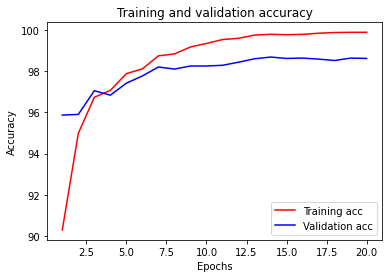

In [0]:
print(len(train_accuracies),len(val_accuracies))
epochs = range(1, len(train_accuracies) + 1)

plt.plot(epochs, train_accuracies, 'r', label='Training acc')
plt.plot(epochs, val_accuracies, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

20 20


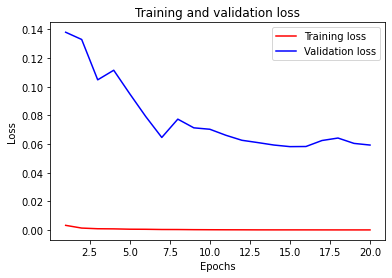

In [0]:
print(len(train_losses),len(val_losses))
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
score = test(model, device, test_loader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.0652, Accuracy: 9878/10000 (99%)

Test loss: 0.06519967160224914
Test accuracy: 98.78


The optimal configuration indeed allowed us to improve results even further, ultimately yielding **98.78%**. I am sure that finer tuning of parameters would allow us to make the model even stronger. We, however, have more things to try, such as tahn activation function. Let's leave it to TF-Keras.

Just in case, Google Colab link: https://colab.research.google.com/drive/18SvlVEvil-O9yjfc5yBWd2_JrV4pwgAE